In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Jupiter  MacOS
# BASE_DIR = "/Users/johnhanratty/Library/CloudStorage/OneDrive-Personal/IRMA_GIT/Kaggle_SignLanguage/asl-signs"
# WORKING_DIR = BASE_DIR
# !pip install nb_black --quiet
# %load_ext lab_black

# Colab
BASE_DIR = "/content/asl-signs"   #"/content/drive/MyDrive/GaggleSignLang/asl-signs"
WORKING_DIR = "/content/asl-work"
# !pip install nb_black --quiet
# print('-----ok')
# %load_ext nb_black

# KAGGLE
# BASE_DIR = "/kaggle/input/asl-signs"
# WORKING_DIR = "/kaggle/working/"
# !pip install nb_black --quiet --root-user-action=ignore
# %load_ext lab_black

import os
import gc
import shutil
import time

import json
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings(action='ignore')

LANDMARK_FILES_DIR = f'{BASE_DIR}/train_landmark_files'
TRAIN_FILE = f"{BASE_DIR}/train.csv"

FRAMES_OUT = 12 #16 # 16
PTS_IN_FRAME = 115
DIMC = [0,1,2]
DIMS = len(DIMC)

  
HANDIDX = {"WRIST":0, "THUMB_CMC":1, "THUMB_MCP":2,     "THUMB_IP":3,          "THUMB_TIP":4,
        "INDEX_FINGER_MCP":5, "INDEX_FINGER_PIP":6,  "INDEX_FINGER_DIP":7,  "INDEX_FINGER_TIP":8,
        "MIDDLE_FINGER_MCP":9,"MIDDLE_FINGER_PIP":10,"MIDDLE_FINGER_DIP":11,"MIDDLE_FINGER_TIP":12,
        "RING_FINGER_MCP":13, "RING_FINGER_PIP":14,  "RING_FINGER_DIP":15,  "RING_FINGER_TIP":16,
        "PINKY_FINGER_MCP":17,"PINKY_FINGER_PIP":18,  "PINKY_FINGER_DIP":19,"PINKY_FINGER_TIP":20}

POSEIDX = {"NOSE":0,        "LEFT_EYE_INNER":1,"LEFT_EYE":2,   "LEFT_EYE_OUTER":3, "RIGHT_EYE_INNER":4, "RIGHT_EYE":5,      "RIGHT_EYE_OUTER":6,
        "LEFT_EAR":7,    "RIGHT_EAR":8,     "MOUTH_LEFT":9, "MOUTH_RIGHT":10,   "LEFT_SHOULDER":11,  "RIGHT_SHOULDER":12,
        "LEFT_ELBOW":13, "RIGHT_ELBOW":14,  "LEFT_WRIST":15, "RIGHT_WRIST":16, 
        "LEFT_PINKY":17, "RIGHT_PINKY":18,  "LEFT_INDEX":19,"RIGHT_INDEX":20,   "RIGHT_THUMB":21,    "LEFT_THUMB":22,
        "LEFT_HIP":23,   "RIGHT_HIP":24,    "LEFT_KNEE":25, "RIGHT_KNEE":26,    "LEFT_ANKLE":27,     "RIGHT_ANKLE":28,
        "LEFT_HEEL":29,  "RIGHT_HEEL":30,   "LEFT_FOOT_INDEX":31, "RIGHT_FOOT_INDEX":32}

LIPSIDX = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
LIPSIDX_sm = [185, 39, 0,  269,  409,  78,  80,  82,  312,  310,  308,  88,  87,  317,  318,  146,  181,  17,  405, 375]


# need to rerun parquet processing to grab data points
#LIPSIDX1 = [12, 268,271,272,407, 293, 325,319,403,316,15,86,179,89,96,62, 183,42,41,38]

METALEN = len(LIPSIDX) + len(POSEIDX) + 2 * len(HANDIDX)

def PRIM_HAND(idx): return(40 + HANDIDX[idx])
def POSE(idx):  return(40 + 21 + POSEIDX[idx])
def SEC_HAND(idx):  return(40 + 21 + 33 + HANDIDX[idx])

print(POSE("NOSE"))
print(SEC_HAND("WRIST"))
METALEN

print('done')


61
94
done


In [3]:
# GET FEATURE FILES FROM GDRIVE 
# COLAB ONLY - MOVE FEATURE FILES TO WORKING DIRECTORY
# 
import os
import gc
import shutil

if os.getenv("COLAB_RELEASE_TAG") and not os.path.exists(WORKING_DIR):
  !mkdir '/content/asl-work'

if os.getenv("COLAB_RELEASE_TAG"):
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_data{FRAMES_OUT}.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_labels.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/sign_to_prediction_index_map.json", f"{WORKING_DIR}")



In [17]:
# PREPOCESS-A  - FRAMES OUTPUT
import psutil

def preProc():
  dx = np.load(f"{WORKING_DIR}/feature_data{FRAMES_OUT}.npy")
  datay = np.load(f"{WORKING_DIR}/feature_labels.npy") 

  data_rows = dx.shape[0]

  print("DX BASE", dx.base)   #BASE1 ROOT READ FROM FILE
  print("dx shape", dx.shape)
  # MAKE COPY OF DX1 input from file
  dx = dx.reshape((data_rows, FRAMES_OUT, -1, 3))  # BASE 1
  print("DX BASE", dx.base[0,0,0]) 

  # DEFINE VIEW MATRICES 
  start_lips =  0
  start_left =  PRIM_HAND("WRIST")
  start_pose =  POSE("NOSE")
  start_right = SEC_HAND("WRIST")
  end_right =   METALEN

  lips_3d =   dx[:, :, 0:PRIM_HAND("WRIST"), :]
  lefth_3d =  dx[:, :, PRIM_HAND("WRIST"):POSE("NOSE"), :]
  pose_3d =   dx[:, :, POSE("NOSE"):SEC_HAND("WRIST"),:]
  righth_3d = dx[:, :, SEC_HAND("WRIST"):METALEN, :]   # BASE1
  print("BASE RIGHT", righth_3d.base[0,0,0])

  # Combind Componets to dx
  dx=np.concatenate((lips_3d, lefth_3d, pose_3d, righth_3d), axis=2)  ## COPY
  print("CONCATX BASE", dx.base)  # BASE2 ROOT
  
  split_bar = '='*20
  memory_info = psutil.virtual_memory()._asdict()
  print(f"{split_bar} Memory Usage {split_bar}")
  for k,v in memory_info.items():
    print(k, v)

  MIRROR = True
  if MIRROR: 
      # Mirror data on x-axis (max-value)
      lips_m = lips_3d
      lips_m[:,:,:,0] = np.nanmax(lips_3d[:,:,:,0]) - lips_3d[:,:,:,0]
      left_m = lefth_3d
      left_m[:,:,:,0] = np.nanmax(lefth_3d[:,:,:,0]) - lefth_3d[:,:,:,0]
      pose_m = pose_3d
      pose_m[:,:,:,0] = np.nanmax(pose_3d[:,:,:,0]) - pose_3d[:,:,:,0]
      right_m = righth_3d
      print("RIGHT_M BASE1", right_m.base[0,0,0])
      right_m[:,:,:,0] = np.nanmax(righth_3d[:,:,:,0]) - righth_3d[:,:,:,0]
      print("RIGHT_M BASE2", right_m.base[0,0,0])

      # NOTE: reversed and swapped position of left_m and right_m 
      # so last slot is primary hand
      datam = np.concatenate((lips_m, right_m, pose_m, left_m), axis=2)
      print("DATAM", datam.shape)

      # find primary hand (Count NaNs)
      #  -check whether lefth_3d OR righth_3d has more NaNs
      cl = lefth_3d.reshape(lefth_3d.shape[0],-1)
      cr = righth_3d.reshape(lefth_3d.shape[0],-1)
      cc = np.isnan(cl).sum(axis=1) > np.isnan(cr).sum(axis=1)
      dx[cc,:,:,:] = datam[cc,:,:,:]  # replace 

  memory_info = psutil.virtual_memory()._asdict()
  print(f"{split_bar} Memory Usage {split_bar}")
  for k,v in memory_info.items():
    print(k, v)

  # REPLACE NaNs
  print('DX NANS FOR REPLACEMENT', np.isnan(dx).sum())
  #dx = np.nan_to_num(dx, copy=False)

  # SET 3D or 2D (SELECT dim columns)
  print(dx.shape)
  if DIMS !=3:
    dx = datax[:,:,:,DIMC]

  print("FINAL SHAPE")
  print("dx", dx.shape)
  print("datay", datay.shape)
  return(dx, datay)

# FINAL SHAPE separate line for seq and feature

datax, datay = preProc()


DX BASE None
dx shape (94477, 12, 345)
DX BASE 0.4689520001411438
BASE RIGHT 0.4689520001411438
CONCATX BASE None
==================== Memory Usage ====================
total 89639657472
available 75036012544
percent 16.3
used 13688512512
free 53575806976
active 3866079232
inactive 31116894208
buffers 375955456
cached 21999382528
shared 21979136
slab 655888384
RIGHT_M BASE1 0.5005468130111694
RIGHT_M BASE2 0.5005468130111694
DATAM (94477, 12, 115, 3)
==================== Memory Usage ====================
total 89639657472
available 70755221504
percent 21.1
used 17969303552
free 49294897152
active 3866132480
inactive 35389399040
buffers 375980032
cached 21999476736
shared 21979136
slab 655671296
DX NANS FOR REPLACEMENT 133096737
(94477, 12, 115, 3)
FINAL SHAPE
dx (94477, 12, 115, 3)
datay (94477,)


In [6]:
# LOAD POLYGON DATA - FRAMES
import pickle

with open(f"/content/drive/MyDrive/GaggleSignLang/area_out3.pkl", 'rb') as handle:
       area_out = pickle.load(handle)


In [6]:
### POLYGONS Build Primary Hand Polygons and save to pickle file
#!pip install pyny3d

#Calculate area
import pyny3d.geoms as pyny
import pickle

datax1 = datax
print(datax1.shape)
def fun(x,):
    x = x.reshape(-1,3)
    x = x[~np.isnan(x).any(axis=1), :]
    if x.shape[0] <3:
        return np.nan
    poly = pyny.Polygon(x)
  
    #RETURNS value {arez, [a,b,c,d]} where a*x + b*y + c*z = 0
    a,b,c,d = poly.get_parametric()
    return poly.get_area(), a,b,c,d


start_time = time.perf_counter()

hlist = [["WRIST", "INDEX_FINGER_MCP", "PINKY_FINGER_MCP"],
         ["WRIST", "MIDDLE_FINGER_TIP", "INDEX_FINGER_TIP"],
         ["WRIST", "THUMB_TIP", "PINKY_FINGER_TIP"]]
#[["INDEX_FINGER_MCP", "THUMB_TIP", "INDEX_FINGER_PIP"],
#         ["INDEX_FINGER_MCP", "MIDDLE_FINGER_TIP", "INDEX_FINGER_TIP"],
#         ["WRIST", "INDEX_FINGER_TIP", "PINKY_FINGER_TIP"]]

area_out = np.zeros([datax1.shape[0]*datax1.shape[1], 5*len(hlist)], dtype=float)

for i,d in enumerate(hlist):
  print("##### PRIM_HAND", i)
  pts = [PRIM_HAND(d[0]), PRIM_HAND(d[1]), PRIM_HAND(d[2])]
  print(pts)
  dd = datax1[:,:, pts, :]
  
  ar  = np.apply_along_axis(fun, 1, dd.reshape(dd.shape[0]*dd.shape[1], -1)) 
  area_out[:,5*i:5*i+5] = ar #get area for each {frame}

  print("#### ELAPSED TIME:", time.perf_counter()-start_time)

with open(f"/content/drive/MyDrive/GaggleSignLang/area_out3.pkl", 'wb') as handle:
  pickle.dump(area_out, handle)
print("DONE")
print(area_out.shape)
print(area_out)

print("#### FINAL TIME:", time.perf_counter()-start_time)


ModuleNotFoundError: ignored

# PCA Encoding

In [18]:
from sklearn.decomposition import PCA
COMPONENTS = 60
print(datax.shape)

datax = np.nan_to_num(datax, copy=False)
shp = datax.shape
pca_X = PCA(n_components=COMPONENTS, random_state=999) 
pca_X.fit(datax.reshape(shp[0]*shp[1], -1))
datax = pca_X.transform(datax.reshape(shp[0]*shp[1],-1))
datax = datax.reshape(shp[0], shp[1], -1)
print(datax.shape)
print(np.cumsum(pca_X.explained_variance_ratio_ *100))

(94477, 12, 115, 3)
(94477, 12, 60)
[68.15231123 84.94340179 90.48732108 93.03172458 95.27435208 96.86694077
 97.66410759 98.12266214 98.53504286 98.86545556 99.05463205 99.19830885
 99.33173914 99.43853574 99.52210114 99.58573996 99.63897819 99.6903257
 99.73200034 99.77266457 99.80858464 99.8324579  99.85121796 99.86568491
 99.87896749 99.89128917 99.8992612  99.90654604 99.91361065 99.91981338
 99.92565531 99.93090955 99.93575182 99.94043058 99.94502614 99.94885983
 99.9526034  99.95594589 99.95900133 99.96154154 99.96403486 99.9663792
 99.96844433 99.9704435  99.97216303 99.97382321 99.97513761 99.9763741
 99.97757374 99.97870193 99.97977293 99.98075923 99.98164851 99.98247118
 99.98325829 99.98403346 99.98473024 99.9854134  99.98608866 99.98675743]


In [8]:
datax.shape

(94477, 1, 60)

# TSAI INCEPTION
## Data
https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/01a_MultiClass_MultiLabel_TSClassification.ipynb 
## TS Model
https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/00c_Time_Series_data_preparation.ipynb 


In [19]:
!pip install tsai --quiet
from tsai.all import *
my_setup()

os              : Linux-5.10.147+-x86_64-with-glibc2.31
python          : 3.9.16
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.0+cu118
device          : 1 gpu (['NVIDIA A100-SXM4-40GB'])
cpu cores       : 6
threads per cpu : 2
RAM             : 83.48 GB
GPU memory      : [40.0] GB


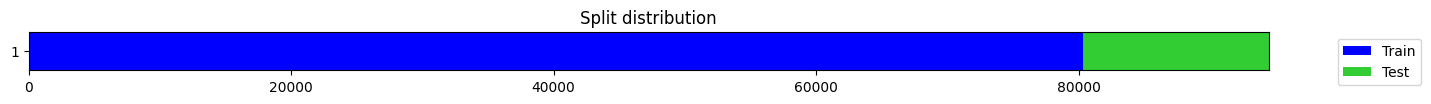

(94477, 345, 16) (94477,)


In [25]:
#TSAI DATASET
# EPOCHS = 40
# BATCH_SIZE = 64
# X = datax.reshape(datax.shape[0], datax.shape[1], -1)
# X = np.swapaxes(X,2,1)
# Y = datay
# tfms  = [None, TSClassification()] # TSClassification == Categorize
# batch_tfms = TSStandardize()
# splits = get_splits(Y, valid_size=.15, random_state=0, shuffle=False)
# dls = get_ts_dls(X, datay, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=BATCH_SIZE)
# X = np.nan_to_num(X, copy=False)
# print(X.shape, Y.shape)

# InceptionTimePlus

In [23]:
# INSTEAD OF PREVIOUS CELL
# USE np data already split
# https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/00c_Time_Series_data_preparation.ipynb 

EPOCHS = 40
BATCH_SIZE = 64

def tsai_dls(datax, datay):
  datax = datax.reshape(datax.shape[0], datax.shape[1], -1)
  datax = np.swapaxes(datax,2,1)
  datax = np.nan_to_num(datax, copy=False)

  trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

  X, Y, splits = combine_split_data([trainx, testx], [trainy, testy])
  tfms  = [None, TSClassification()] # TSClassification == Categorize
  batch_tfms = TSStandardize()

  #dsets = TSDatasets(X, Y, tfms=tfms, splits=splits, inplace=True)
  #dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize())

  dls = get_ts_dls(X, Y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=BATCH_SIZE)
  print(X.shape, Y.shape)
  return dls, X, Y, splits

dls, X, Y, splits = tsai_dls(datax, datay)

(94477, 60, 12) (94477,)


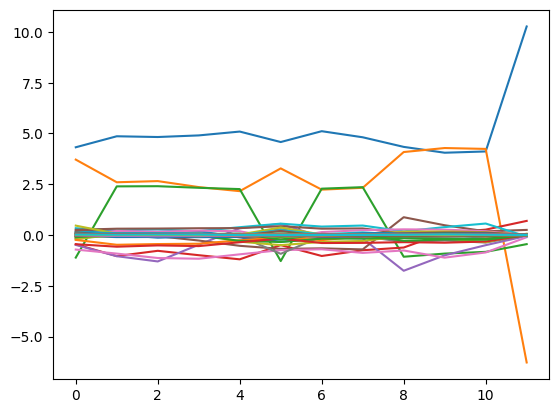

In [15]:
plt.plot(X[4].T);

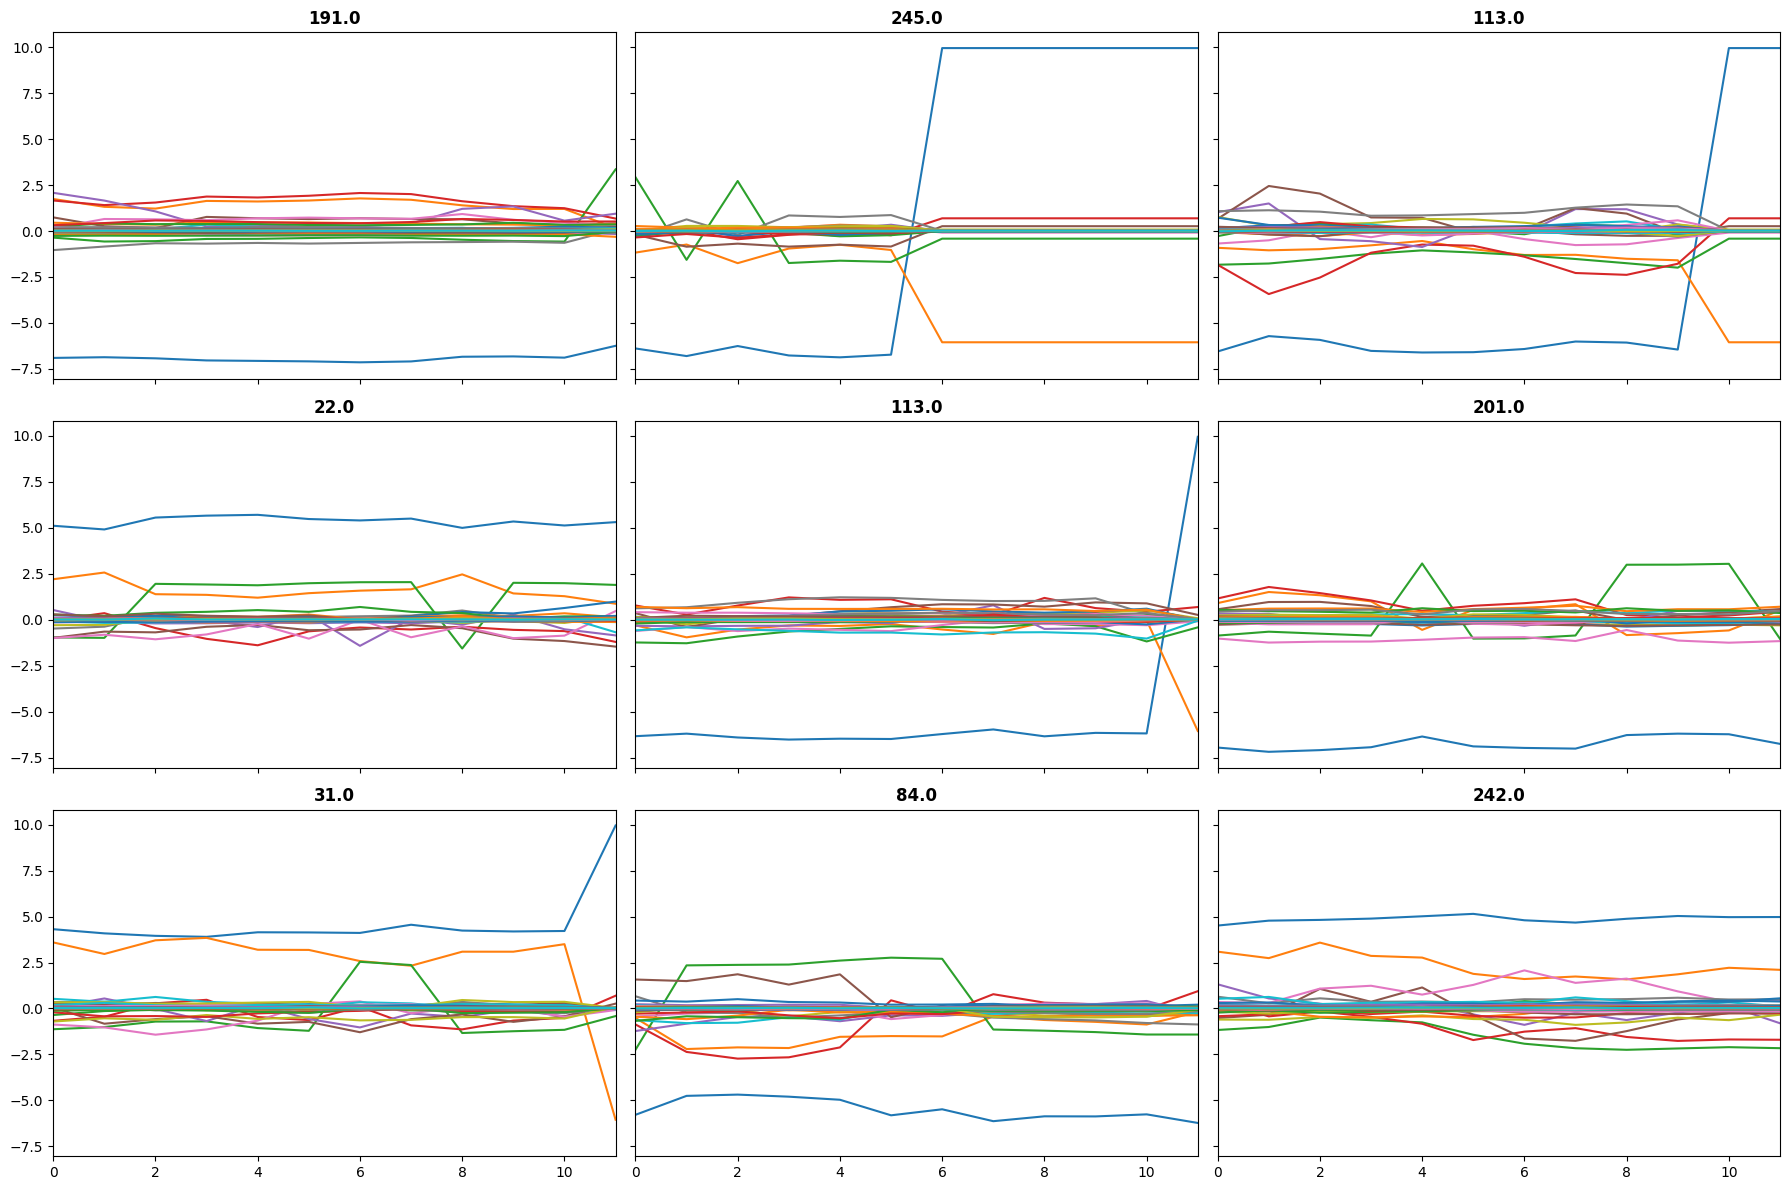

In [16]:
dls.show_batch(sharey=True)

SuggestedLRs(valley=0.00019054606673307717)

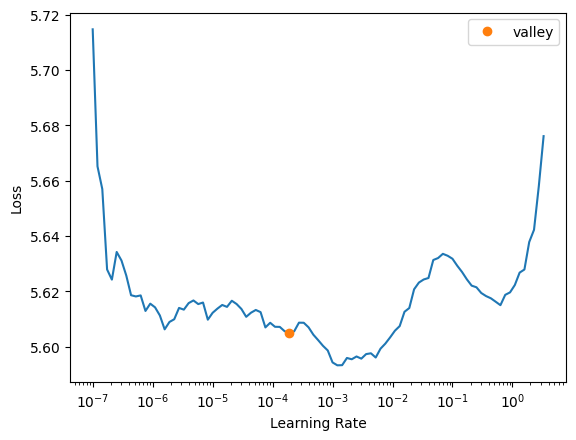

In [37]:
model = build_ts_model(InceptionTimePlus, dls=dls, depth=9, nf=64, fc_dropout=0, conv_dropout=0)  
learn = Learner(dls, model, metrics=accuracy)
learn = ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) # == ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) since InceptionTimePlus is the default arch
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,4.381163,4.338431,0.096952,00:23
1,3.051493,2.967759,0.305038,00:23
2,2.298686,2.213352,0.460979,00:23
3,2.063218,2.063289,0.496754,00:24
4,1.901450,1.848461,0.548052,00:24
5,1.756530,1.781562,0.558990,00:23
6,1.683162,1.698848,0.582063,00:23
7,1.636871,1.632361,0.598222,00:23
8,1.482751,1.586371,0.611205,00:23
9,1.424312,1.513617,0.630116,00:23


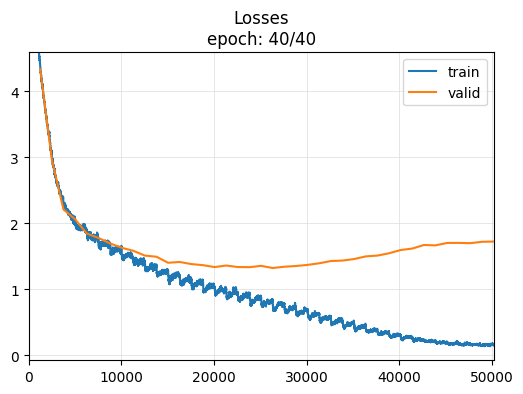

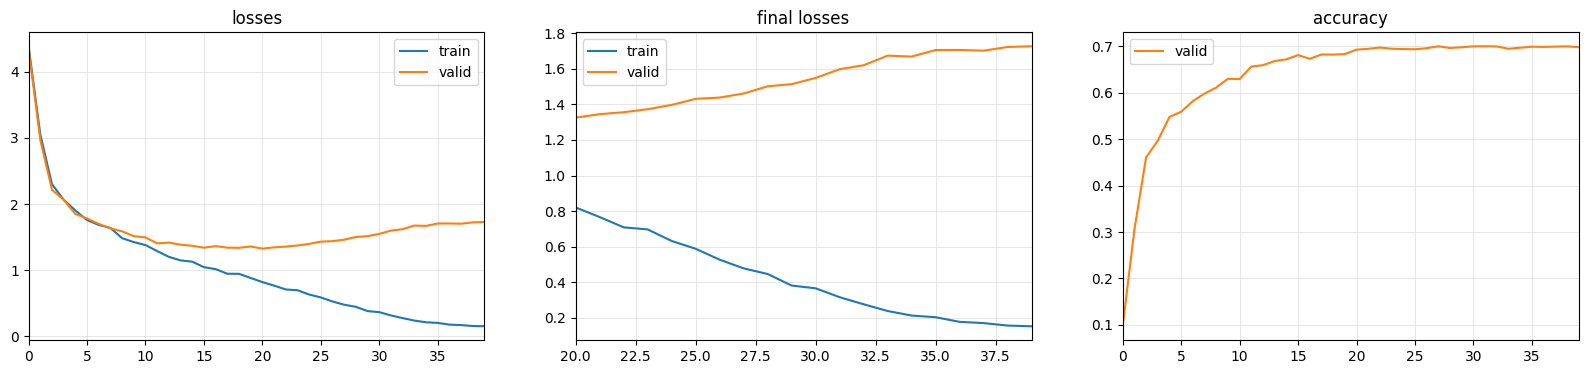

In [38]:
learn = ts_learner(dls, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(EPOCHS, lr_max=4.5e-3)


In [24]:
datax.shape

(94477, 12, 115, 3)

In [ ]:
### RESULTS  TRANSFORMER
# 35	1.709165	2.143427	0.692704 # datax/no pca/no poly/16 frames - default conv_dropout=.0
# 39	0.391030	1.305315	0.712108 # data/no pca/no poly/24 frames  - default drconv_dropoutop=.0
# 33	0.237616	1.653893	0.676404 #data/60 pca/no poly/12 frames  - default conv_dropout=.0
# 26	0.734834	1.532440	0.644228 #data/no pca/no poly/12 frames  - default conv_dropout=.0  # night run longer
# 31	0.511150	1.481988	0.673723 #data/60 pca/no poly/12 frames  - default conv_dropout=.2 

# 39	0.156111	1.711687	0.699196  #data/60 pca/no poly/12 frames  - depth=9, nf=64, fc_dropout=0, conv_dropout=0.2 
# 37	0.170784	1.701637	0.699407  #data/60 pca/no poly/12 frames  - depth=9, nf=64, fc_dropout=0, conv_dropout=0.0 

In [ ]:
#EXPORT MODEL
PATH = Path('./models/Multiclass.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)
     

In [ ]:
## NOT FINISHED
# https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/01a_MultiClass_MultiLabel_TSClassification.ipynb 
#GPU
PATH = Path('./models/Multiclass.pkl')
learn_gpu = load_learner(PATH, cpu=False)
# gpu, many samples
probas, _, preds = learn_gpu.get_X_preds(X[splits[1]])
preds[-10:]
skm.accuracy_score(new_y[splits[1]], preds)

## CPU
PATH = Path('./models/Multiclass.pkl')
learn_cpu = load_learner(PATH, cpu=True)
# cpu, single sample
probas, _, preds = learn_cpu.get_X_preds(X[-1][None]) # [None] is added to pass a 3D array with dimensions [batch_size x n_vars x seq_len]
preds 


# TSAI TRANSFORMERS

SuggestedLRs(valley=8.31763736641733e-06)

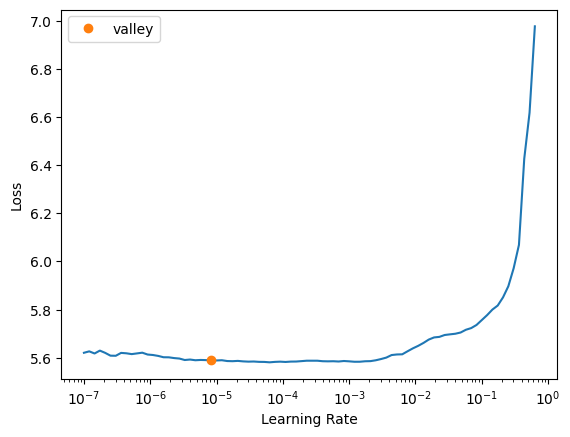

In [10]:
model = TST(dls.vars, dls.c, dls.len, dropout=0.3)
# learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()



# model = build_ts_model(InceptionTimePlus, dls=dls)
# learn = Learner(dls, model, metrics=accuracy)
# learn = ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) # == ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) since InceptionTimePlus is the default arch





epoch,train_loss,valid_loss,accuracy,time
0,5.569110,5.530098,0.004939,00:24
1,5.523728,5.484070,0.010161,00:24
2,5.359754,5.313991,0.016864,00:23
3,5.140039,5.077500,0.040785,00:24
4,4.654346,4.549375,0.108594,00:23
5,4.140623,3.993639,0.222410,00:24
6,3.758395,3.593484,0.304968,00:24
7,3.436274,3.307343,0.383714,00:23
8,3.232992,3.042620,0.443127,00:24
9,3.024720,2.878201,0.483630,00:26


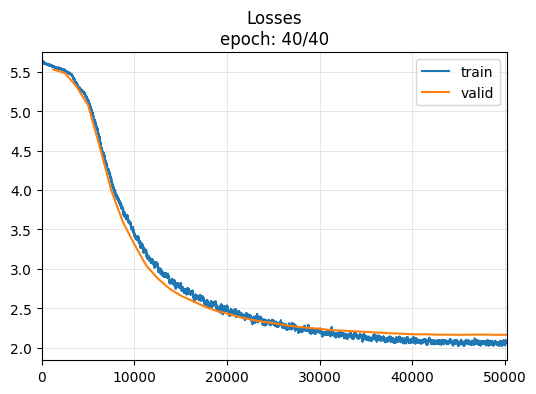

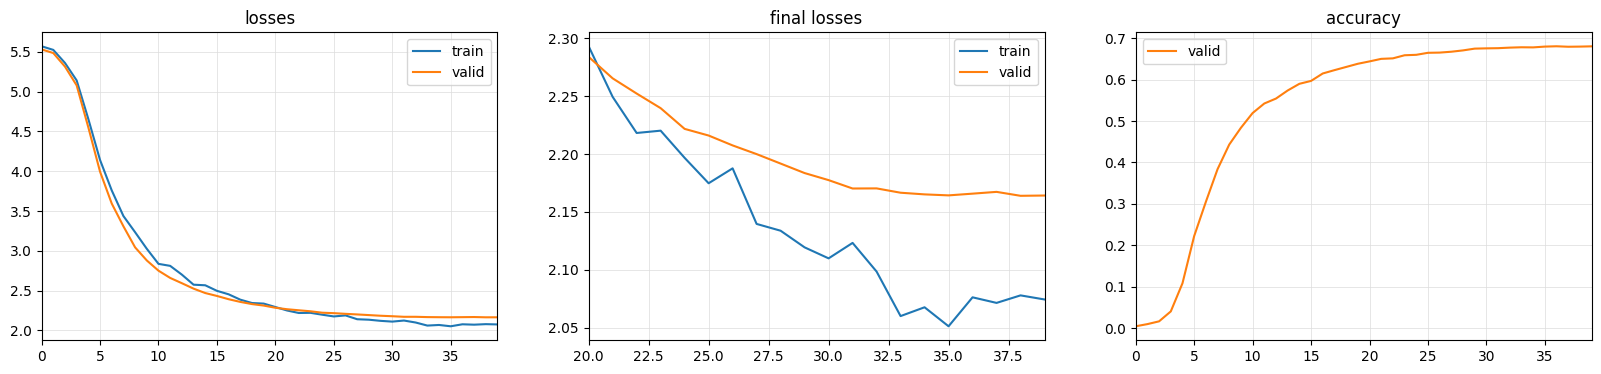


Elapsed time: 1040.7067124843597


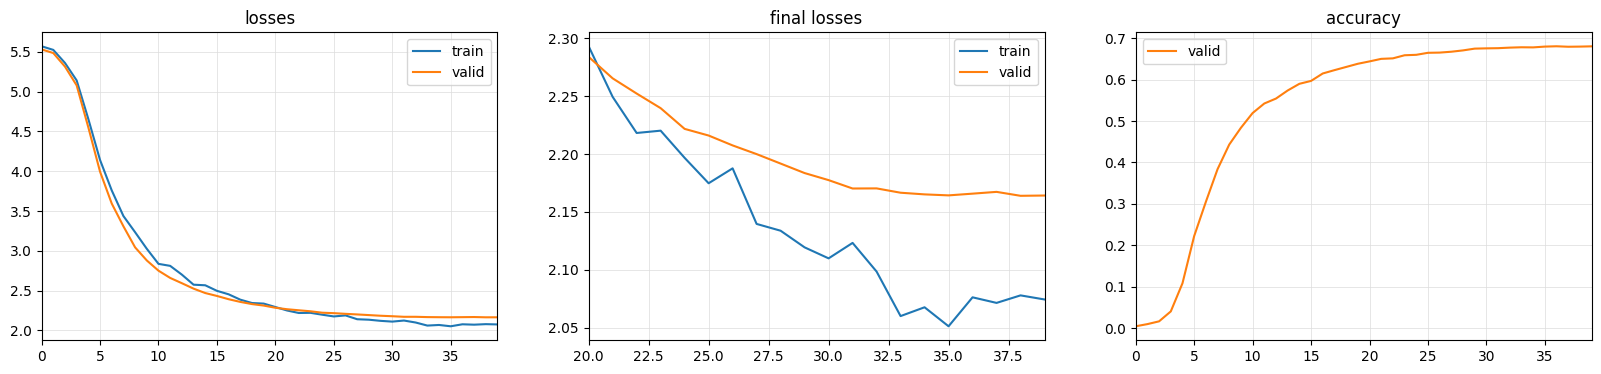

In [39]:
model = TST(dls.vars, dls.c, dls.len, dropout=0.1, fc_dropout=0.3, n_heads=12)  #dropout=0-0.3. Default: 0.1, fc_dropout=0-0.8. Default: 0
#learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(EPOCHS, lr_max=1e-4)
print('\nElapsed time:', time.time() - start)
learn.plot_metrics()

In [ ]:
## RESULTS  TRANSFORMER
# 35	1.709165	2.143427	0.696796 # datax/no pca/no poly/16 frames, dropout=.1, 1e-4 
# 39	3.432315	3.390544	0.367132  # datax/no pca/no poly/24 frames, dropout=.3, 1e-5 may not have finished
# 38	1.903378	2.211974	0.678098  # datax/no pca/no poly/24 frames, dropout=.3, 1e-4
# 39	1.563823	2.193949	0.683390  # datax/no pca/no poly/24 frames, dropout=.1, 1e-4
# 39	2.205843	2.092617	0.691787  # datax/no pca/no poly/24 frames, dropout=0.1, fc_dropout=0.8 , 1e-4
# 39	1.758983	2.110572	0.700889  # datax/no pca/no poly/24 frames, dropout=0.1, fc_dropout=0.3
# 39	1.967697	2.123454	0.691293  # #datax/no pca/no poly/12 frames, dropout=0.1, fc_dropout=0.3
# 39	2.067334	2.163853	0.682331 #datax/60 pca/no poly/12 frames, dropout=0.1, fc_dropout=0.3

# 39	2.074385	2.164184	0.680073	(stillgoing)  ##datax/60 pca/no poly/12 frames,dropout=0.1, fc_dropout=0.3, n_heads=12

# Hyperparameter Tuning

In [21]:
!pip install optuna --quiet
import optuna
from optuna.integration import FastAIPruningCallback

def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    nf = trial.suggest_categorical('num_filters', [32, 64, 96]) # search through all categorical values in the provided list
    depth = trial.suggest_int('depth', 3, 9, step=3) # search through all integer values between 3 and 9 with 3 increment steps
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    batch_tfms = TSStandardize(by_sample=True)
    learn = TSClassifier(X, Y, splits=splits, bs=[64, 128], batch_tfms=batch_tfms,
                         arch=InceptionTimePlus, arch_config={'nf':nf, 'fc_dropout':dropout_rate, 'depth':depth},
                         metrics=accuracy, cbs=FastAIPruningCallback(trial))


    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(5, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][1] # return the validation loss value of the last epoch 

In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-04-13 21:05:43,289] A new study created in memory with name: no-name-0c63c14f-bc35-4368-ab92-877bba7482f3
[I 2023-04-13 21:07:59,993] Trial 0 finished with value: 13463.1435546875 and parameters: {'num_filters': 32, 'depth': 6, 'dropout_rate': 0.2, 'learning_rate': 6.759221071997634e-05}. Best is trial 0 with value: 13463.1435546875.
[I 2023-04-13 21:11:03,569] Trial 1 finished with value: 9077.162109375 and parameters: {'num_filters': 64, 'depth': 9, 'dropout_rate': 0.4, 'learning_rate': 6.202952724194989e-05}. Best is trial 1 with value: 9077.162109375.
[I 2023-04-13 21:13:21,521] Trial 2 finished with value: 4883.82958984375 and parameters: {'num_filters': 96, 'depth': 6, 'dropout_rate': 0.1, 'learning_rate': 0.00021666080261935458}. Best is trial 2 with value: 4883.82958984375.
[I 2023-04-13 21:16:25,321] Trial 3 finished with value: 4853.6650390625 and parameters: {'num_filters': 64, 'depth': 9, 'dropout_rate': 0.4, 'learning_rate': 0.0002463382833865945}. Best is trial 3 

In [25]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
     

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  4240.5380859375
  Params: 
    num_filters: 64
    depth: 9
    dropout_rate: 0.0
    learning_rate: 0.004588792901621258


In [26]:
display(optuna.visualization.plot_optimization_history(study))
display(optuna.visualization.plot_param_importances(study))
display(optuna.visualization.plot_slice(study))
display(optuna.visualization.plot_parallel_coordinate(study))